# su2nn: SU(2) and time-reversal equivariant neural network for quantum spin system

## 1. Introduction

The first obvious quantum spin effect we can observe is in the field of magnetism. Magnetism is important because it is crucial in various technological applications, such as data storage, electric motors, and generators. In addition, magnetic materials have been widely studied in condensed matter physics, where understanding their magnetic properties can provide insights into fundamental phenomena such as quantum phase transitions and spin dynamics. Moreover, the most recent theoretical developments of quantum spin have led to many applications in advanced fields like topological material, lossless electronics, and quantum information.

Quantum spin is the quantum angular momentum internal degree of freedom. Together with the external counterpart, the quantum angular momentum has SU(2) as its symmetry group, i.e. it can be described by a representation of the group of 2 by 2 unitary matrices with unit determinant. It also turns out that SU(2) is a Lie group with exactly the same Lie algebra as SO(3), up to the generators equivalence. This means that SU(2) is homomorphic to SO(3), but SU(2) is more fundamental in describing quantum systems. Furthermore, spin systems can also break the time-reversal symmetry which is a discrete symmetry similar to parity but for temporal instead of spatial. With this nature of quantum spin system’s symmetry, it is straight forward to attempt the generalization of e3nn package that is already SO(3) and parity equivariant to also SU(2) and time-reversal equivariant in order to make a machine learning model that is suitable to the symmetry of the spin system.

In this project, we modified the source code of e3nn, specifically the irreducible representation classes, to handle the SU(2) symmetry group, i.e. expanding integer angular number requirement to include half-integer, and increase the discrete symmetry channel of time-reversal on top of parity. We then propagated the change of this class through out the whole e3nn package. After that, we tested the sanity of the modified package with various equivariant properties we learned in class, and performed experiments with some simple quantum spin systems.

## 2. Related Works

Machine learning has been increasingly applied to predicting material properties, including spin, due to its potential to enhance accuracy and efficiency compared to traditional methods. There are works taking the symmetry described in SU(2) to represent the property of spin in a reasonable way. 

Machine learning helps us understand the relationship between spin configuration and other material properties. Models are proposed for predicting the properties of quantum materials, like the topological features of their electronic structures, using spin configuration as input. Also, there are models predicting spin states. A  neural network model to predict whether the spin is up or down, providing the electronic configurations of transition-metal compounds. This is important for understanding their magnetic and electronic properties. The model utilizes local crystal structure as input to predict electronic configurations accurately. Another work proposes a machine learning method using an artificial neural network to represent a complex spin Hamiltonian, which can be used to study spin systems. The method utilizes a feedforward neural network with a modified activation function to represent the Hamiltonian and shows promising results in predicting the behavior of spin systems.

A graph neural network (GNN) is the most common approach to studying the structure-property relationship of materials, as it can take the geometrical aspect of materials into the models. A graph neural network model can predict material properties incorporating local and global information about the material structure. The model utilizes residual correlation to enhance the accuracy of prediction performance through the work using spin states of the Ising model. Another model utilizes the local environment of each atom in the material to predict its magnetic moment and shows improved accuracy compared to traditional methods.

We can use machine learning to detect and evaluate the specific symmetry of the dataset. One work presents a neural network method for detecting symmetries like the one in SU(2), which can be applied to identify symmetry-protected topological phases. The method utilizes convolutional neural networks to learn the features of the data and then applies group theoretic techniques to extract the symmetries. Another model work presents a machine learning approach to learning order parameters of SU(2) lattice gauge theory, which describes the behavior of spin systems. The method utilizes a neural network to learn the mapping from spin configurations to the corresponding order parameters and shows promising results in predicting the behavior of spin systems.

## 3. Background
### 3.1 SU(2) Irreducible Representation
Similar to the process for SO(3) in lectures, one can start from the definition of SU(2) as a group of 2 by 2 unitary matrices with unit determinant. This entails that each member of the group can be written in the form
$$
    U = e^{-iA} \tag{1}
$$
with 
$$
    A^\dag = A, \text{Tr}A = 0. \tag{2}
$$
From this criteria, we can deduce one possible selection of the generators as
$$
\begin{align}
    A &= \begin{bmatrix}c & a - ib \\ a + ib & - c\end{bmatrix} \nonumber\\
    &= a\cdot\sigma_x + b\cdot\sigma_y + c\cdot\sigma_z \nonumber\\
    &= (a, b, c)\cdot\vec{\sigma} \nonumber\\
    &\equiv \dfrac{1}{2}\vec{\sigma}\cdot\hat{n}\phi
\end{align} \tag{3}
$$
where $\sigma$'s are Pauli matrices, $\hat{n}$ is the unit vector in $(a, b, c)$ direction, and $\phi$ is twice the magnitude of $(a, b, c)$. These choices of parameters are for the consistency with the quantum spin community.

Since $\sigma_z$ is the only diagonal generator, it is trivial that the generators are of irreducible representation. Furthermore, the commutation relation of the Pauli matrix is
$$
    [\sigma_p/2, \sigma_q/2] = i\epsilon_{pqr}\sigma_r/2, \tag{4}
$$
which is exactly the same as SO(3)'s Lie algebra. This means that we can directly define
$$
\begin{align}
    J^{(1/2)}_{p\in\{x, y, z\}} &\equiv \sigma_p/2 \\
    (J^{(1/2)})^2 &\equiv (J^{(1/2)}_x)^2 + (J^{(1/2)}_y)^2 + (J^{(1/2)}_z)^2
\end{align} \tag{5}
$$
where $(J^{(1/2)})^2$ commute with $J^{(1/2)}_{p\in\{x, y, z\}}$. Hence, we can choose to label states with eigenvalues of $(J^{(1/2)})^2$ and $J^{(1/2)}_z$ which are $j(j+1)$ and $m$ where $j = 1/2$ and $m \in \{1/2, -1/2\}$. From here, one can use tensor product together with representation reduction to generate all orders of representations with $j\in\{0, 1/2, 1, 3/2, ...\}$.

Because of these equivalence in algebra between SO(3) and SU(2), we can use ladder operator trick to get the ladder operators' matrix representations which, in turn, gives the matrix representations of $J^{(j)}_{p\in\{x, y\}}$. ($J^{(j)}_z$ is trivial with our of choice of state and the fact that $m\in\{-j, -j+1, ..., j-1, j\}$.) In fact, the e3nn package actually uses this SU(2) generator method and restrict the value of $l$ (instead of $j$) to be integer.

### 3.2 Time-Reversal Symmetry

## 4. Method

## 5. Results
### 5.1 Irreducible representations

In [1]:
from su2nn_e3nn_core.su2 import Irreps, Irrep
from e3nn import o3
from ase import Atoms
import torch
from torch_geometric.data import Data, DataLoader
import numpy as np
import pandas as pd
from project.model import GraphConvolution, GraphNetwork, Convolution, Network, irreps_o3_to_su2, irreps_su2_to_o3
from project.data import generate_data_dict

In [2]:
# physical vector 
irreps = Irreps("1oe")
irreps

1x1oe

In [3]:
# spin
irreps2 = Irreps("1eo")
irreps2

1x1eo

In [4]:
irreps3 = Irreps("0.5eo")
irreps3

1x1/2eo

In [5]:
# Tuple[Tuple[int, Tuple[int, int]]]
# ((multiplicity, (l, p)), ...)

print(len(irreps))
mul_ir = irreps[0]  # a tuple

print(mul_ir)
print(len(mul_ir))
mul = mul_ir[0]  # an int
ir = mul_ir[1]  # another tuple

print(mul)

print(ir)
# print(len(ir))  ir is a tuple of 2 ints but __len__ has been disabled since it is always 2
l = ir[0]
p = ir[1]

print(l, p)

1
1x1oe
2
1
1oe
1 -1


In [6]:
import torch
t = torch.tensor

# show the transformation matrix corresponding to the inversion
irreps.D_from_angles(alpha=t(0.0), beta=t(0.0), gamma=t(0.0), k=t(1))

tensor([[-1.+0.j, -0.+0.j, -0.+0.j],
        [-0.+0.j, -1.+0.j, -0.+0.j],
        [-0.+0.j, -0.+0.j, -1.+0.j]])

In [7]:
# a small rotation around the y axis
irreps.D_from_angles(alpha=t(0.1), beta=t(0.0), gamma=t(0.0), k=t(0))

tensor([[0.9950+0.0998j, 0.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 1.0000+0.0000j, 0.0000+0.0000j],
        [0.0000+0.0000j, 0.0000+0.0000j, 0.9950-0.0998j]])

## 5.2 Rotation by D matrix

[]

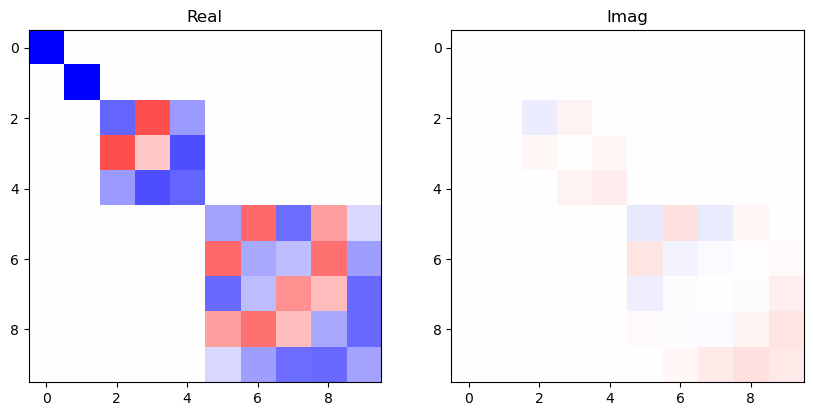

In [8]:
irreps = Irreps("2x0oe + 1x1eo + 1x2oe")
# irreps = Irreps("1x5.5eo")
from su2nn_e3nn_core import su2
rot = -su2.rand_matrix()

D = irreps.D_from_angles(torch.tensor([30]), torch.tensor([50]), torch.tensor([10]))
D = irreps.D_from_matrix(rot)
# print(D)

D = D.reshape(irreps.dim, irreps.dim)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize = (10, 5))
ax1, ax2 = axs[0], axs[1]
ax1.imshow(D.real, cmap='bwr', vmin=-1, vmax=1)
ax1.set_title('Real')
ax2.imshow(D.imag, cmap='bwr', vmin=-1, vmax=1)
ax2.set_title('Imag')
plt.plot()

[]

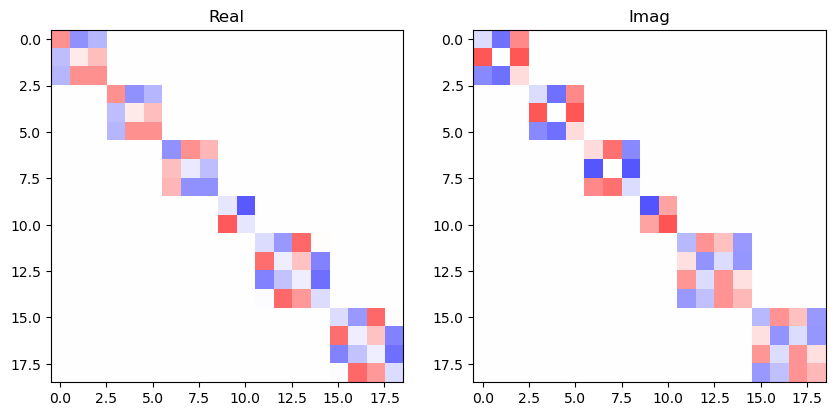

In [9]:
irreps = Irreps("2x1oe + 1x1eo +1x0.5eo + 1x1.5oe + 1x1.5oo")
from su2nn_e3nn_core import su2
rot = -su2.rand_matrix()

D = irreps.D_from_matrix(rot)
# print(D)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize = (10, 5))
ax1, ax2 = axs[0], axs[1]
ax1.imshow(D.real, cmap='bwr', vmin=-1, vmax=1)
ax1.set_title('Real')
ax2.imshow(D.imag, cmap='bwr', vmin=-1, vmax=1)
ax2.set_title('Imag')
plt.plot()

## 5.3 Convolution

In [10]:
import torch
from torch_cluster import radius_graph
from torch_scatter import scatter
from su2nn_e3nn_core import su2, nn
from su2nn_e3nn_core.math import soft_one_hot_linspace
import matplotlib.pyplot as plt

In [11]:
irreps_input = su2.Irreps("10x0ee + 10x1eo")
irreps_output = su2.Irreps("20x0ee + 10x1eo")

In [12]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions
# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)
print(edge_src.shape)
edge_vec = pos[edge_dst] - pos[edge_src]
# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([3426])


34.26

In [13]:
# create node positions
num_nodes = 100
pos = torch.randn(num_nodes, 3)  # random node positions
# create edges
max_radius = 1.8
edge_src, edge_dst = radius_graph(pos, max_radius, max_num_neighbors=num_nodes - 1)
print(edge_src.shape)
edge_vec = pos[edge_dst] - pos[edge_src]
# compute z
num_neighbors = len(edge_src) / num_nodes
num_neighbors

torch.Size([2972])


29.72

In [14]:
f_in = irreps_input.randn(num_nodes, -1)

In [15]:
f_in.pow(2).mean()  # should be close to 1

tensor(1.0008)

In [16]:
# irreps_sh = su2.Irreps.spherical_harmonics(lmax=2)
lmax = 3
irreps_sh_o3 = o3.Irreps.spherical_harmonics(lmax)
irreps_sh_su2 = irreps_o3_to_su2(irreps_sh_o3)
print(f'{irreps_sh_o3}  --> {irreps_sh_su2}')
print(f'{irreps_sh_su2}  --> {irreps_su2_to_o3(irreps_sh_su2)}')

sh = o3.spherical_harmonics(irreps_sh_o3, edge_vec, normalize=True, normalization='component')
# normalize=True ensure that x is divided by |x| before computing the sh

sh.pow(2).mean()  # should be close to 1

1x0e+1x1o+1x2e+1x3o  --> 1x0ee+1x1oe+1x2ee+1x3oe
1x0ee+1x1oe+1x2ee+1x3oe  --> 1x0e+1x1o+1x2e+1x3o


tensor(1.)

## 5.4 Tensor product

FullyConnectedTensorProduct(10x0ee+10x1eo x 1x0ee+1x1oe+1x2ee+1x3oe -> 20x0ee+10x1eo | 400 paths | 400 weights) needs 400 weights


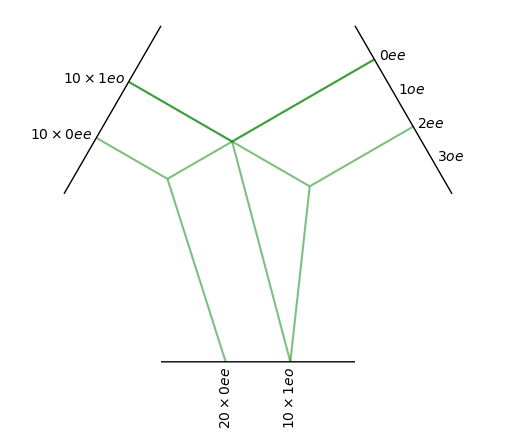

In [17]:
tp = su2.FullyConnectedTensorProduct(irreps_input, irreps_sh_su2, irreps_output, shared_weights=False)

print(f"{tp} needs {tp.weight_numel} weights")

tp.visualize();

FullTensorProduct(2x1oe+1x1/2eo+1x3/2oo x 1x1eo+1x1/2oe -> 3x0oo+1x1/2oe+3x1/2ee+3x1oo+1x1eo+1x3/2oe+3x3/2ee+2x2oo+1x2eo+1x5/2oe | 19 paths | 0 weights)


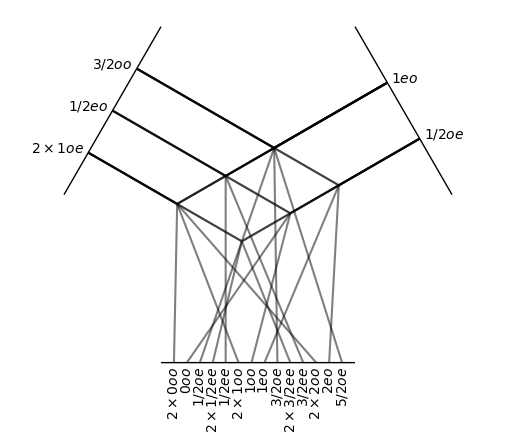

In [18]:
irreps_in1 = Irreps("2x1oe+1x0.5eo+1x1.5oo")
irreps_in2 = Irreps("1x1eo+1x0.5oe")
tp2 = su2.FullTensorProduct(irreps_in1, irreps_in2)

print(tp2)

tp2.visualize();

## 5.5 Equivariance check

In [19]:
irreps_node_feature = Irreps('1x1eo')   # spin with l=1
irreps_in= irreps_node_feature  #Irreps(str(input_embed_dim)+'x0ee')
lmax=2
device='cuda:7'
irreps_edge_attr_o3 = o3.Irreps.spherical_harmonics(lmax)
irreps_sh=irreps_o3_to_su2(irreps_edge_attr_o3, t='o')
irreps_out='1x0oe+1x1oe+2x1ee+1x2oe+1x2ee+1x3ee' 
num_neighbors=4
conv = Convolution(irreps_in, irreps_sh, irreps_out, num_neighbors)
print(conv)
conv.to(device)
number_of_basis =3
tol = 1e-3

Convolution(
  (fc): FullyConnectedNet[3, 256, 9]
  (tp): FullyConnectedTensorProduct(1x1eo x 1x0eo+1x1oo+1x2eo -> 1x0oe+1x1oe+2x1ee+1x2oe+1x2ee+1x3ee | 9 paths | 9 weights)
)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

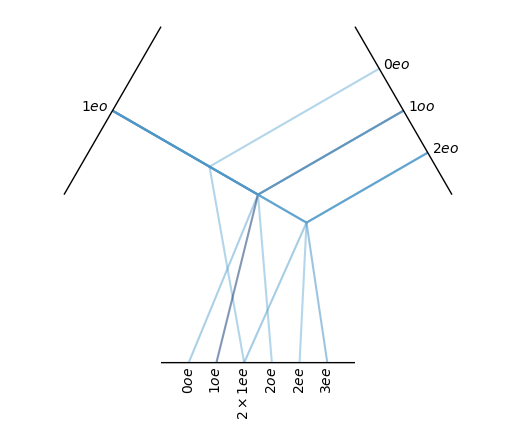

In [20]:
ftp = su2.FullyConnectedTensorProduct('1x1eo', '1x0eo+1x1oo+1x2eo', '1x0oe+1x1oe+2x1ee+1x2oe+1x2ee+1x3ee')
ftp.visualize()

### case1: physical coordinate is rotated, spins are static

In [21]:
natms = 3
nsystems = 20
element = 'H'
r_max = 4
pos0 = np.random.rand(natms,3)
spins = np.random.rand(natms,irreps_node_feature.dim)
df = pd.DataFrame({})
for idx in range(nsystems):
    Data = dict()
    if idx==0:
        rot = np.eye(3)
        pos = pos0
    else:
        rot = np.array(su2.rand_matrix(1).reshape((3,3)))
        pos = pos0@rot
        
    system = Atoms(element + str(natms), positions=pos)
    Data['id'] = idx
    Data['system'] = [system]
    Data['spins'] = [spins]
    Data['rot'] = [rot]
    dfn = pd.DataFrame(data = Data)
    df = pd.concat([df, dfn], ignore_index = True)

data_dict = generate_data_dict(df, r_max)
batch_size = 1
data_set = torch.utils.data.Subset(list(data_dict.values()), range(len(data_dict)))
tr_set, te_set = torch.utils.data.Subset(data_set, range(18)), torch.utils.data.Subset(data_set, [18,19])
tr_loader = DataLoader(tr_set, batch_size = batch_size)
te_loader = DataLoader(te_set, batch_size = batch_size)

/home/rokabe/anaconda3/envs/pdos/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [22]:
print(df['system']) # rotated

0     (Atom('H', [0.6130707483482756, 0.412672112565...
1     (Atom('H', [0.5524753761291286, 0.733698643742...
2     (Atom('H', [-0.17133744206510507, -0.718621856...
3     (Atom('H', [-0.7830663465816167, 0.53101465516...
4     (Atom('H', [0.006059748681595371, -0.939908634...
5     (Atom('H', [0.6258563303023641, -0.73558935470...
6     (Atom('H', [-0.585330587649349, 0.651939921496...
7     (Atom('H', [-0.46198873274498925, 0.7853195743...
8     (Atom('H', [0.8723489419693786, -0.04612915266...
9     (Atom('H', [-0.6474522058873596, 0.63488243963...
10    (Atom('H', [-0.3420571931688558, -0.6524464225...
11    (Atom('H', [0.14901173530384854, -0.9563253782...
12    (Atom('H', [0.9566494974200976, 0.021393339201...
13    (Atom('H', [-0.5471226802459392, -0.7332833256...
14    (Atom('H', [-0.09389176603742844, -0.616493779...
15    (Atom('H', [-0.7266344584541106, 0.56855149235...
16    (Atom('H', [0.9242631893530346, 0.309524325786...
17    (Atom('H', [0.285250543673448, 0.936541459

In [23]:
print(df['spins'])  # static

0     [[0.2853853356933579, 0.31891163039008075, 0.9...
1     [[0.2853853356933579, 0.31891163039008075, 0.9...
2     [[0.2853853356933579, 0.31891163039008075, 0.9...
3     [[0.2853853356933579, 0.31891163039008075, 0.9...
4     [[0.2853853356933579, 0.31891163039008075, 0.9...
5     [[0.2853853356933579, 0.31891163039008075, 0.9...
6     [[0.2853853356933579, 0.31891163039008075, 0.9...
7     [[0.2853853356933579, 0.31891163039008075, 0.9...
8     [[0.2853853356933579, 0.31891163039008075, 0.9...
9     [[0.2853853356933579, 0.31891163039008075, 0.9...
10    [[0.2853853356933579, 0.31891163039008075, 0.9...
11    [[0.2853853356933579, 0.31891163039008075, 0.9...
12    [[0.2853853356933579, 0.31891163039008075, 0.9...
13    [[0.2853853356933579, 0.31891163039008075, 0.9...
14    [[0.2853853356933579, 0.31891163039008075, 0.9...
15    [[0.2853853356933579, 0.31891163039008075, 0.9...
16    [[0.2853853356933579, 0.31891163039008075, 0.9...
17    [[0.2853853356933579, 0.31891163039008075,

In [24]:
for i, d in enumerate(tr_loader):
    d.to(device)
    num_neighbors = d['numb']
    edge_src = d['edge_index'][0]
    edge_dst = d['edge_index'][1]
    edge_vec = d['edge_vec']
    edge_len = d['edge_len']
    edge_length_embedded = soft_one_hot_linspace(edge_len, 0.0, d['r_max'].item(), number_of_basis, basis = 'gaussian', cutoff = False)
    edge_sh = o3.spherical_harmonics(irreps_edge_attr_o3, edge_vec, True, normalization = 'component')
    edge_attr = edge_sh
    numb = d['numb']
    x = torch.tensor(d.x).to(device)
    d.to(device)
    out = conv(x, edge_src, edge_dst, edge_attr, edge_length_embedded)
    rot = d.rot
    D =conv.irreps_out.D_from_matrix(rot.cpu())
    D = D.double().to(device)
    out_rot = out@D.T
    diff = out - out_rot
    # print(out[:2])
    print(torch.allclose(diff, torch.zeros_like(diff), atol=tol))

/tmp/ipykernel_5459/3494912306.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(d.x).to(device)
/tmp/ipykernel_5459/3494912306.py:17: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:244.)
  D = D.double().to(device)


True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


### case2: spins is rotated, physical coordinate is static

In [25]:
natms = 3
nsystems = 20
element = 'H'
r_max = 4
pos0 = np.random.rand(natms,3)
spins0 = np.random.rand(natms,irreps_node_feature.dim)
df = pd.DataFrame({})
for idx in range(nsystems):
    Data = dict()
    if idx==0:
        rot = np.eye(3)
        spins = spins0
    else:
        rot = np.array(su2.rand_matrix(1).reshape((3,3)))
        spins = spins0@rot
        
    system = Atoms(element + str(natms), positions=pos0)
    Data['id'] = idx
    Data['system'] = [system]
    Data['spins'] = [spins]
    Data['rot'] = [rot]
    dfn = pd.DataFrame(data = Data)
    df = pd.concat([df, dfn], ignore_index = True)

data_dict = generate_data_dict(df, r_max)
batch_size = 1
data_set = torch.utils.data.Subset(list(data_dict.values()), range(len(data_dict)))
tr_set, te_set = torch.utils.data.Subset(data_set, range(18)), torch.utils.data.Subset(data_set, [18,19])
tr_loader = DataLoader(tr_set, batch_size = batch_size)
te_loader = DataLoader(te_set, batch_size = batch_size)

In [26]:
print(df['system']) # static

0     (Atom('H', [0.5575631448633078, 0.193807233673...
1     (Atom('H', [0.5575631448633078, 0.193807233673...
2     (Atom('H', [0.5575631448633078, 0.193807233673...
3     (Atom('H', [0.5575631448633078, 0.193807233673...
4     (Atom('H', [0.5575631448633078, 0.193807233673...
5     (Atom('H', [0.5575631448633078, 0.193807233673...
6     (Atom('H', [0.5575631448633078, 0.193807233673...
7     (Atom('H', [0.5575631448633078, 0.193807233673...
8     (Atom('H', [0.5575631448633078, 0.193807233673...
9     (Atom('H', [0.5575631448633078, 0.193807233673...
10    (Atom('H', [0.5575631448633078, 0.193807233673...
11    (Atom('H', [0.5575631448633078, 0.193807233673...
12    (Atom('H', [0.5575631448633078, 0.193807233673...
13    (Atom('H', [0.5575631448633078, 0.193807233673...
14    (Atom('H', [0.5575631448633078, 0.193807233673...
15    (Atom('H', [0.5575631448633078, 0.193807233673...
16    (Atom('H', [0.5575631448633078, 0.193807233673...
17    (Atom('H', [0.5575631448633078, 0.19380723

In [27]:
print(df['spins'])  # rotated

0     [[0.6507500131892174, 0.11951137755867935, 0.8...
1     [[0.9244431996301206, 0.2306652605447768, 0.49...
2     [[-0.051532832482965474, -0.062302581531615706...
3     [[-0.9664978722288959, -0.4651010580905883, -0...
4     [[0.7182550674554521, 0.6379749768963697, -0.4...
5     [[1.0388203745291797, 0.2663137558373709, -0.0...
6     [[0.6573335434238459, -0.2813636199000706, 0.7...
7     [[-1.0468376850817231, -0.13938996145009372, -...
8     [[0.8686007862420639, 0.6289688195255438, -0.0...
9     [[-0.570871648497365, -0.7753679296286686, 0.4...
10    [[-0.9921435113370527, 0.40394449080861866, -0...
11    [[-0.30659509981502425, -0.39390206647551856, ...
12    [[-0.2734778219369802, 0.9414839822363569, 0.4...
13    [[0.9572901975341147, -0.43958814789290807, 0....
14    [[0.9064881401749115, -0.39557104075907124, 0....
15    [[0.0738018277223973, 1.0375525044977698, 0.26...
16    [[-0.19909942525235275, -0.8867426179821031, -...
17    [[-0.5156196607792242, 0.9317414429173647,

In [28]:
for i, d in enumerate(tr_loader):
    d.to(device)
    num_neighbors = d['numb']
    edge_src = d['edge_index'][0]
    edge_dst = d['edge_index'][1]
    edge_vec = d['edge_vec']
    edge_len = d['edge_len']
    edge_length_embedded = soft_one_hot_linspace(edge_len, 0.0, d['r_max'].item(), number_of_basis, basis = 'gaussian', cutoff = False)
    edge_sh = o3.spherical_harmonics(irreps_edge_attr_o3, edge_vec, True, normalization = 'component')
    edge_attr = edge_sh
    numb = d['numb']
    x = torch.tensor(d.x).to(device)
    d.to(device)
    out = conv(x, edge_src, edge_dst, edge_attr, edge_length_embedded)
    rot = d.rot
    D =conv.irreps_out.D_from_matrix(rot.cpu())
    D = D.double().to(device)
    out_rot = out@D.T
    diff = out - out_rot
    # print(out[:2])
    print(torch.allclose(diff, torch.zeros_like(diff), atol=tol))

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/tmp/ipykernel_5459/3494912306.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(d.x).to(device)


### case3: both physical coordinate and spins are rotated

In [29]:
natms = 3
nsystems = 20
element = 'H'
r_max = 4
pos0 = np.random.rand(natms,3)
spins0 = np.random.rand(natms,irreps_node_feature.dim)
df = pd.DataFrame({})
for idx in range(nsystems):
    Data = dict()
    if idx==0:
        rot = np.eye(3)
        pos = pos0
        spins = spins0
    else:
        rot = np.array(su2.rand_matrix(1).reshape((3,3)))
        pos = pos0@rot
        spins = spins0@rot
        
    system = Atoms(element + str(natms), positions=pos)
    Data['id'] = idx
    Data['system'] = [system]
    Data['spins'] = [spins]
    Data['rot'] = [rot]
    dfn = pd.DataFrame(data = Data)
    df = pd.concat([df, dfn], ignore_index = True)

data_dict = generate_data_dict(df, r_max)
batch_size = 1
data_set = torch.utils.data.Subset(list(data_dict.values()), range(len(data_dict)))
tr_set, te_set = torch.utils.data.Subset(data_set, range(18)), torch.utils.data.Subset(data_set, [18,19])
tr_loader = DataLoader(tr_set, batch_size = batch_size)
te_loader = DataLoader(te_set, batch_size = batch_size)

In [30]:
print(df['system']) # rotated

0     (Atom('H', [0.34767523505948816, 0.51280012433...
1     (Atom('H', [0.5559380914927228, 0.411939218177...
2     (Atom('H', [0.7027314200851076, 0.206297540979...
3     (Atom('H', [0.8061136087048537, -0.06687256675...
4     (Atom('H', [0.46145835156328285, -0.3885310057...
5     (Atom('H', [-0.11798956229879262, -0.025471115...
6     (Atom('H', [0.19333379114728455, -0.1964472993...
7     (Atom('H', [0.49709122484970414, -0.1723354694...
8     (Atom('H', [-0.02201167058109018, 0.2771905787...
9     (Atom('H', [0.03665263116211537, -0.4764763252...
10    (Atom('H', [0.2305349221440412, 0.401664224884...
11    (Atom('H', [-0.17738619813907525, -0.184899173...
12    (Atom('H', [-0.3075672406038782, 0.71225277983...
13    (Atom('H', [-0.5157055991193669, 0.52000728368...
14    (Atom('H', [0.615051541090313, 0.4459020350011...
15    (Atom('H', [0.1361913208813998, 0.181321589948...
16    (Atom('H', [-0.5154863286912571, 0.16382660396...
17    (Atom('H', [0.01613057277834158, -0.079754

In [31]:
print(df['spins'])  # rotated

0     [[0.5860275618664551, 0.5027432473044839, 0.23...
1     [[0.7517459107566552, 0.2506544962529077, -0.1...
2     [[0.46941325218092605, 0.5355815095811358, 0.3...
3     [[0.7145383743473075, 0.32582728599573174, -0....
4     [[0.4373883744925883, 0.0035365856999679947, -...
5     [[-0.1093879283805887, 0.36194122856989447, -0...
6     [[0.5165631136725927, -0.023831515177549646, 0...
7     [[0.4265599965582898, 0.22591177429345133, 0.6...
8     [[-0.4019519063214848, 0.21577574450687342, -0...
9     [[-0.2739423833143599, -0.22020098739703398, 0...
10    [[-0.05090037393599673, 0.6234058864657523, 0....
11    [[-0.15482717064921017, -0.5304324500583522, 0...
12    [[-0.5858608135499349, 0.5520705830097984, -0....
13    [[-0.29722157110016784, 0.7371353262178604, -0...
14    [[0.3081207537730118, 0.695734948816609, -0.27...
15    [[0.4194127370397733, 0.36616577338843237, 0.5...
16    [[-0.36064993591505334, -0.20622556116927485, ...
17    [[0.2343655864670093, 0.2453293783572339, 

In [32]:
for i, d in enumerate(tr_loader):
    d.to(device)
    num_neighbors = d['numb']
    edge_src = d['edge_index'][0]
    edge_dst = d['edge_index'][1]
    edge_vec = d['edge_vec']
    edge_len = d['edge_len']
    edge_length_embedded = soft_one_hot_linspace(edge_len, 0.0, d['r_max'].item(), number_of_basis, basis = 'gaussian', cutoff = False)
    edge_sh = o3.spherical_harmonics(irreps_edge_attr_o3, edge_vec, True, normalization = 'component')
    edge_attr = edge_sh
    numb = d['numb']
    x = torch.tensor(d.x).to(device)
    d.to(device)
    out = conv(x, edge_src, edge_dst, edge_attr, edge_length_embedded)
    rot = d.rot
    D =conv.irreps_out.D_from_matrix(rot.cpu())
    D = D.double().to(device)
    out_rot = out@D.T
    diff = out - out_rot
    # print(out[:2])
    print(torch.allclose(diff, torch.zeros_like(diff), atol=tol))

True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


/tmp/ipykernel_5459/3494912306.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(d.x).to(device)
